In [17]:
# Data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# MLflow
import mlflow
from mlflow.models.signature import infer_signature
from mlflow.tracking import MlflowClient
import inspect

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    confusion_matrix, ConfusionMatrixDisplay, mean_absolute_error,
    mean_squared_error
)
import matplotlib.pyplot as plt
import mlflow
import warnings
import inspect
from mlflow.models.signature import infer_signature
import numpy as np
import pandas as pd

from mord import LogisticAT
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor

from mord import LogisticAT 
from utils import log_linear_model_run 

from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
warnings.filterwarnings(
    "ignore",
    message=".*Inferred schema contains integer column.*",
    category=UserWarning,
    module="mlflow.types.utils"
)

In [3]:
mlflow.set_tracking_uri("file:///C:/Users/Galyna/mlruns")
print(mlflow.get_tracking_uri())

file:///C:/Users/Galyna/mlruns


In [4]:
df = pd.read_csv('data.csv') 

In [5]:
df.head()

,Student_ID,Age,Gender,Academic_Level,Country,Avg_Daily_Usage_Hours,Most_Used_Platform,Affects_Academic_Performance,Sleep_Hours_Per_Night,Mental_Health_Score,Relationship_Status,Conflicts_Over_Social_Media,Addicted_Score
0,1,19,Female,Undergraduate,Bangladesh,5.2,Instagram,Yes,6.5,6,In Relationship,3,8
1,2,22,Male,Graduate,India,2.1,Twitter,No,7.5,8,Single,0,3
2,3,20,Female,Undergraduate,USA,6.0,TikTok,Yes,5.0,5,Complicated,4,9
3,4,18,Male,High School,UK,3.0,YouTube,No,7.0,7,Single,1,4
4,5,21,Male,Graduate,Canada,4.5,Facebook,Yes,6.0,6,In Relationship,2,7


In [6]:
df = pd.read_csv('data.csv') 

In [7]:
exclude_cols = ['Student_ID', 'Conflicts_Over_Social_Media', 'Country', 'Addicted_Score'] 
numeric_cols = df.select_dtypes(include='number').columns
numeric_cols = [col for col in numeric_cols if col not in exclude_cols]
print(numeric_cols)

categoric_cols = df.select_dtypes(include='object').columns
categoric_cols = [col for col in categoric_cols if col not in exclude_cols]
print(categoric_cols)

['Age', 'Avg_Daily_Usage_Hours', 'Sleep_Hours_Per_Night', 'Mental_Health_Score']
['Gender', 'Academic_Level', 'Most_Used_Platform', 'Affects_Academic_Performance', 'Relationship_Status']


In [8]:
numeric_pipe  = Pipeline([('std_scaler', StandardScaler())])
categorical_ohe_pipe = Pipeline([('onehot', OneHotEncoder(handle_unknown='ignore'))])
country_te_pipe = Pipeline([('target_enc', TargetEncoder())])

In [9]:
# Define preprocessing and pipeline
preprocessor = ColumnTransformer([
    ('numeric',          numeric_pipe,      numeric_cols),
    ('categorical_ohe',  categorical_ohe_pipe, categoric_cols),
    ('country_te',       country_te_pipe,   ['Country'])
])

In [10]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

In [11]:
input_cols = numeric_cols + categoric_cols + ['Country']
target_col = 'Addicted_Score'
train_inputs, train_targets = train_df[input_cols].copy(), train_df[target_col].copy()
val_inputs, val_targets = val_df[input_cols].copy(), val_df[target_col].copy()

### Linear Regression

In [12]:
lin_reg_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LinearRegression()) 
])

In [13]:
lin_reg_model.fit(train_inputs, train_targets)

# predict + round
train_preds = np.clip(np.round(lin_reg_model.predict(train_inputs)), 2, 9).astype(int)
val_preds   = np.clip(np.round(lin_reg_model.predict(val_inputs)),   2, 9).astype(int)

In [14]:
params_lr = {
    "model_type": "LinearRegression",
    "test_size": 0.2,
    "random_state": 42,
    "n_features": train_inputs.shape[1]
}

In [15]:
metrics = log_linear_model_run(
    model=lin_reg_model,
    params=params_lr,
    train_X=train_inputs,
    train_y=train_targets,
    val_X=val_inputs,
    val_y=val_targets,
    model_name="LinearRegression_v1",
    experiment_name="Regression models"
)

print("Logged metrics:", metrics)

Logged metrics: {'mae_train': 0.21539439219389878, 'mse_train': 0.08732494982479505, 'rmse_train': 0.295507952219217, 'r2_train': 0.9653111547421126, 'adjusted_r2_train': 0.9646838700177385, 'mae_val': 0.21980320466839018, 'mse_val': 0.08726070140386609, 'rmse_val': 0.29539922376991123, 'r2_val': 0.9651276432296723, 'adjusted_r2_val': 0.9624451542473393}


Registered model 'LinearRegression_v1' already exists. Creating a new version of this model...
Created version '9' of model 'LinearRegression_v1'.


In [18]:
joblib.dump(lin_reg_model, "addiction_score_lin_reg.joblib")

['addiction_score_lin_reg.joblib']

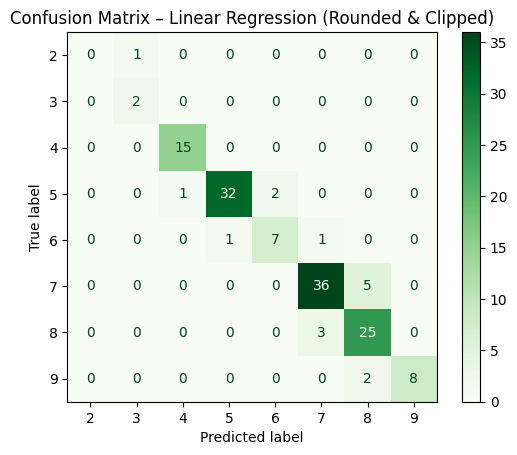

In [20]:
# Generate confusion matrix
cm_linreg = confusion_matrix(val_targets, val_preds, labels=np.arange(2, 10))

# Plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm_linreg, display_labels=np.arange(2, 10))
disp.plot(cmap="Greens", values_format='d')  # or '0.2f' for percentages if normalized
plt.title("Confusion Matrix – Linear Regression (Rounded & Clipped)")
plt.show()

### XGBoost

In [21]:
xgb_reg_model = Pipeline(steps=[
    ("preprocessor", preprocessor),          # ← keeps all your scaling / encoding
    ("regressor", XGBRegressor(              # ← new name & new estimator
        n_estimators=500,        # trees (try 300–1000)
        learning_rate=0.05,      # shrinkage
        max_depth=6,             # tree depth
        subsample=0.8,           # row sampling
        colsample_bytree=0.8,    # column sampling
        objective="reg:squarederror",
        random_state=42,
        n_jobs=-1                # use all CPU cores
    ))
])

In [22]:
xgb_reg_model.fit(train_inputs, train_targets)

train_preds_xgb = np.clip(np.round(xgb_reg_model.predict(train_inputs)), 2, 9).astype(int)
val_preds_xgb   = np.clip(np.round(xgb_reg_model.predict(val_inputs)),   2, 9).astype(int)

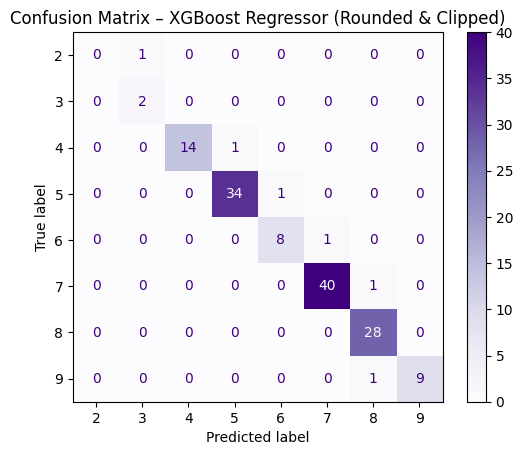

In [23]:
# Step 2: Generate confusion matrix for validation set
cm_xgb = confusion_matrix(val_targets, val_preds_xgb, labels=np.arange(2, 10))

# Step 3: Plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=np.arange(2, 10))
disp.plot(cmap="Purples", values_format='d')
plt.title("Confusion Matrix – XGBoost Regressor (Rounded & Clipped)")
plt.show()

In [24]:
params_xgb_reg = {
    "model_type": "XGBoost Regression",
    "test_size": 0.2,
    "random_state": 42,
    "n_features": train_inputs.shape[1]
}

In [25]:
metrics = log_linear_model_run(
    model=xgb_reg_model,
    params=params_xgb_reg,
    train_X=train_inputs,
    train_y=train_targets,
    val_X=val_inputs,
    val_y=val_targets,
    model_name="XGBoost_Regression_v1",
    experiment_name="Regression models"
)

print("Logged metrics:", metrics)

Logged metrics: {'mae_train': 0.0050391461700201035, 'mse_train': 5.7062326959567145e-05, 'rmse_train': 0.007553961011255429, 'r2_train': 0.9999773502349854, 'adjusted_r2_train': 0.9999769406551479, 'mae_val': 0.08965243399143219, 'mse_val': 0.041623082011938095, 'rmse_val': 0.2040173571339902, 'r2_val': 0.9833660125732422, 'adjusted_r2_val': 0.9820864750788763}


Registered model 'XGBoost_Regression_v1' already exists. Creating a new version of this model...
Created version '5' of model 'XGBoost_Regression_v1'.


### Ordinal Regression (Classification)

In [26]:
ord_reg_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticAT()) 
])

In [27]:
ord_reg_model.fit(train_inputs, train_targets)

train_preds_ord = ord_reg_model.predict(train_inputs)
val_preds_ord   = ord_reg_model.predict(val_inputs)

In [28]:
# -------- Train set --------
mae_train  = mean_absolute_error(train_targets, train_preds)
rmse_train = np.sqrt(mean_squared_error(train_targets, train_preds)) 

# -------- Validation set --------
mae_val  = mean_absolute_error(val_targets, val_preds)
rmse_val   = np.sqrt(mean_squared_error(val_targets, val_preds))

print(f"Train  MAE:  {mae_train:.3f}   |  RMSE: {rmse_train:.3f}")
print(f"Valid. MAE:  {mae_val:.3f}   |  RMSE: {rmse_val:.3f}")

Train  MAE:  0.110   |  RMSE: 0.332
Valid. MAE:  0.113   |  RMSE: 0.337


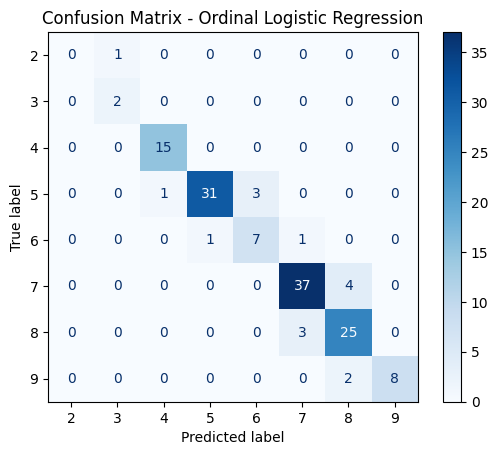

In [29]:
# Confusion matrix on validation set
cm_ord = confusion_matrix(val_targets, val_preds_ord, labels=np.arange(2, 10))

# Display
disp = ConfusionMatrixDisplay(confusion_matrix=cm_ord, display_labels=np.arange(2, 10))
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix - Ordinal Logistic Regression")
plt.show()